## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import zipfile
import os
import matplotlib as ml
import matplotlib.pyplot as plt

In [36]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, RandomTreesEmbedding
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

## GET DATA

In [5]:
def load_train():
    return pd.read_csv('datasets/train.csv')

In [6]:
def load_test():
    return pd.read_csv('datasets/test.csv')

In [7]:
train = load_train()
test = load_test()

## INICIAL DATA ANALYSIS

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

In [25]:
train['Sex'].value_counts() / len(train)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

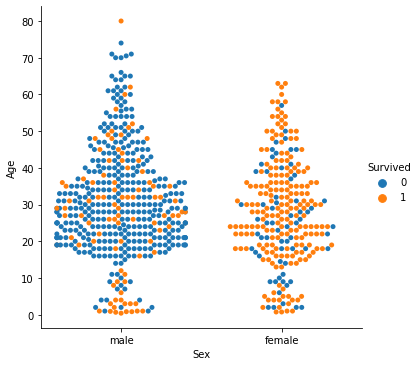

In [27]:
sns.catplot(data=train, kind='swarm', x="Sex", y='Age', hue='Survived')

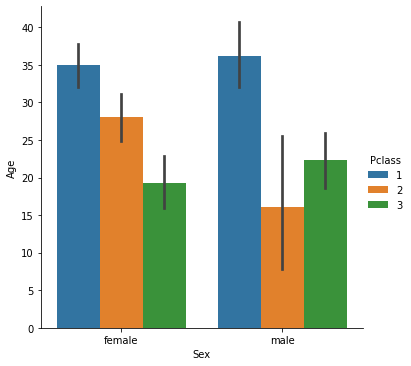

In [31]:
sns.catplot(data=train[train['Survived']==1], kind='bar', x="Sex", y='Age', hue='Pclass')

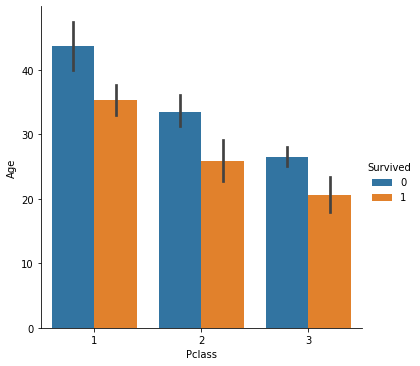

In [34]:
sns.catplot(data=train, kind='bar', x="Pclass", y='Age', hue='Survived')

In [35]:
train['Pclass'].value_counts() / len(train)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

## SETS

In [43]:
from sklearn.model_selection import train_test_split

treino, validacao = train_test_split(train, test_size=0.3, random_state=42)

X_treino = treino.drop("Survived", axis=1)
y_treino = treino['Survived']

X_valid = validacao.drop("Survived", axis=1)
y_valid = validacao['Survived']

## TRASFORMING DATA

#### Pipelines

In [44]:
pipe_fill_scaler = Pipeline([
    ('imp', SimpleImputer(strategy='median')), 
    ('scale', StandardScaler())
])

In [45]:
pipe_cat_attribs = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('num', OneHotEncoder()) 
])

In [46]:
transforms = ColumnTransformer([
    ('fill_scaler', pipe_fill_scaler, ['Age', 'Fare']), 
    ('cat_attribs', pipe_cat_attribs, ['Pclass', 'Sex', 'Embarked'])
])

In [ ]:
models = [DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), KNeighborsClassifier(), SVC(), LogisticRegression()]
labels = ['Age', 'Fare', 'Pclass', 'Sex', 'Embarked']

for model in models:
    pipe = make_pipeline(transforms, model)
    val_scores = cross_val_score(pipe, X, y_train, cv=10)
    nome_modelo = type(model).__name__ # somente para exibição
    print('Modelo: {} | Média: {:.2} | Desvio: {:.2}'.format(nome_modelo, np.mean(val_scores), np.std(val_scores)))